# Case Study: DCube Analytics

### Importing required libraries

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_curve, auc,confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
%matplotlib inline

Using TensorFlow backend.


### Data Preprocessing

In [2]:
data = pd.read_csv('input.csv')
data = data.drop_duplicates()
data = data.dropna()
#Changing the column names to lower case
data.columns = [ x.lower().strip() for x in data.columns]
data.columns

Index(['ptid', 'persistency_flag', 'gender', 'race', 'ethnicity', 'region',
       'age_bucket', 'ntm_speciality', 'ntm_specialist_flag',
       'ntm_speciality_bucket', 'gluco_record_prior_ntm',
       'gluco_record_during_rx', 'dexa_freq_during_rx', 'dexa_during_rx',
       'frag_frac_prior_ntm', 'frag_frac_during_rx', 'risk_segment_prior_ntm',
       'tscore_bucket_prior_ntm', 'risk_segment_during_rx',
       'tscore_bucket_during_rx', 'change_t_score', 'change_risk_segment',
       'adherent_flag', 'idn_indicator', 'injectable_experience_during_rx',
       'comorb_encounter_for_screening_for_malignant_neoplasms',
       'comorb_encounter_for_immunization',
       'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx',
       'comorb_vitamin_d_deficiency',
       'comorb_other_joint_disorder_not_elsewhere_classified',
       'comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx',
       'comorb_long_term_current_drug_therapy', 'comorb_dorsalgia',
       'com

In [3]:
data.shape

(3424, 69)

In [4]:
#Numeric columns present in the data
num_cols = data._get_numeric_data().columns
num_cols

Index(['dexa_freq_during_rx', 'count_of_risks'], dtype='object')

### Combining disease and treatment factor columns into frequency counts 

The disease and treatment factor columns fall under three categories,
1. Concomitancy
2. Comorbidity
3. Risk Factors

We can convert the individual columns into frequency counts and they are,
1. Concomitancy Count
2. Comorbidity Count
3. Risk Factors Count

In [5]:
grouping_dict = {}

grouping = ['concom','comorb','risk']

for val in grouping:
    for col in data.columns:
        if col.startswith(val):
            grouping_dict[col] = val

Each column can be mapped to their respective bucket using a dictionary

In [6]:
grouping_dict

{'concom_cholesterol_and_triglyceride_regulating_preparations': 'concom',
 'concom_narcotics': 'concom',
 'concom_systemic_corticosteroids_plain': 'concom',
 'concom_anti_depressants_and_mood_stabilisers': 'concom',
 'concom_fluoroquinolones': 'concom',
 'concom_cephalosporins': 'concom',
 'concom_macrolides_and_similar_types': 'concom',
 'concom_broad_spectrum_penicillins': 'concom',
 'concom_anaesthetics_general': 'concom',
 'concom_viral_vaccines': 'concom',
 'comorb_encounter_for_screening_for_malignant_neoplasms': 'comorb',
 'comorb_encounter_for_immunization': 'comorb',
 'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx': 'comorb',
 'comorb_vitamin_d_deficiency': 'comorb',
 'comorb_other_joint_disorder_not_elsewhere_classified': 'comorb',
 'comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx': 'comorb',
 'comorb_long_term_current_drug_therapy': 'comorb',
 'comorb_dorsalgia': 'comorb',
 'comorb_personal_history_of_other_diseases_and_conditions': 'como

In [7]:
# Deleting columns which do not fall under the risk factors bucket
del grouping_dict['risk_segment_prior_ntm']
del grouping_dict['risk_segment_during_rx']

combined_columns = [x for x in grouping_dict.keys()]

Converting Yes and No values to 1 and 0 using Label Encoding

In [8]:
le = LabelEncoder()
for val in combined_columns:
    data[val] = le.fit_transform(data[val])

Grouping the values together using groupby function.

In [9]:
to_combine = data.set_index('ptid').groupby(grouping_dict,axis=1).sum()

to_combine.columns = ['concomitancy_count','comorbidity_count','risk_factors_count']

to_combine = to_combine.reset_index()

to_combine.head(5)

,ptid,concomitancy_count,comorbidity_count,risk_factors_count
0,P1,5,0,0
1,P2,1,0,0
2,P3,2,1,2
3,P4,6,3,1
4,P5,5,3,1


### Merging the data:

Removing the individual columns and replacing them with their frequency counts

In [10]:
data = data.drop(combined_columns,axis=1)

data = pd.merge(data, to_combine, on='ptid', how = 'inner')

data=data.drop(['count_of_risks'],axis=1)

In [11]:
data.shape

(3424, 28)

In [12]:
data.describe(include='O')

,ptid,persistency_flag,gender,race,ethnicity,region,age_bucket,ntm_speciality,ntm_specialist_flag,ntm_speciality_bucket,...,frag_frac_during_rx,risk_segment_prior_ntm,tscore_bucket_prior_ntm,risk_segment_during_rx,tscore_bucket_during_rx,change_t_score,change_risk_segment,adherent_flag,idn_indicator,injectable_experience_during_rx
count,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424,...,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424
unique,3424,2,2,4,3,5,4,36,2,3,...,2,2,2,3,3,4,4,2,2,2
top,P2119,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,VLR_LR,>-2.5,Unknown,Unknown,No change,Unknown,Adherent,Y,Y
freq,1,2135,3230,3148,3235,1383,1439,1535,2013,2104,...,3007,1931,1951,1497,1497,1660,2229,3251,2557,3056


## Feature Engineering

The above table shows that there are four columns with unknown values.Lets explore those columns plotting them.

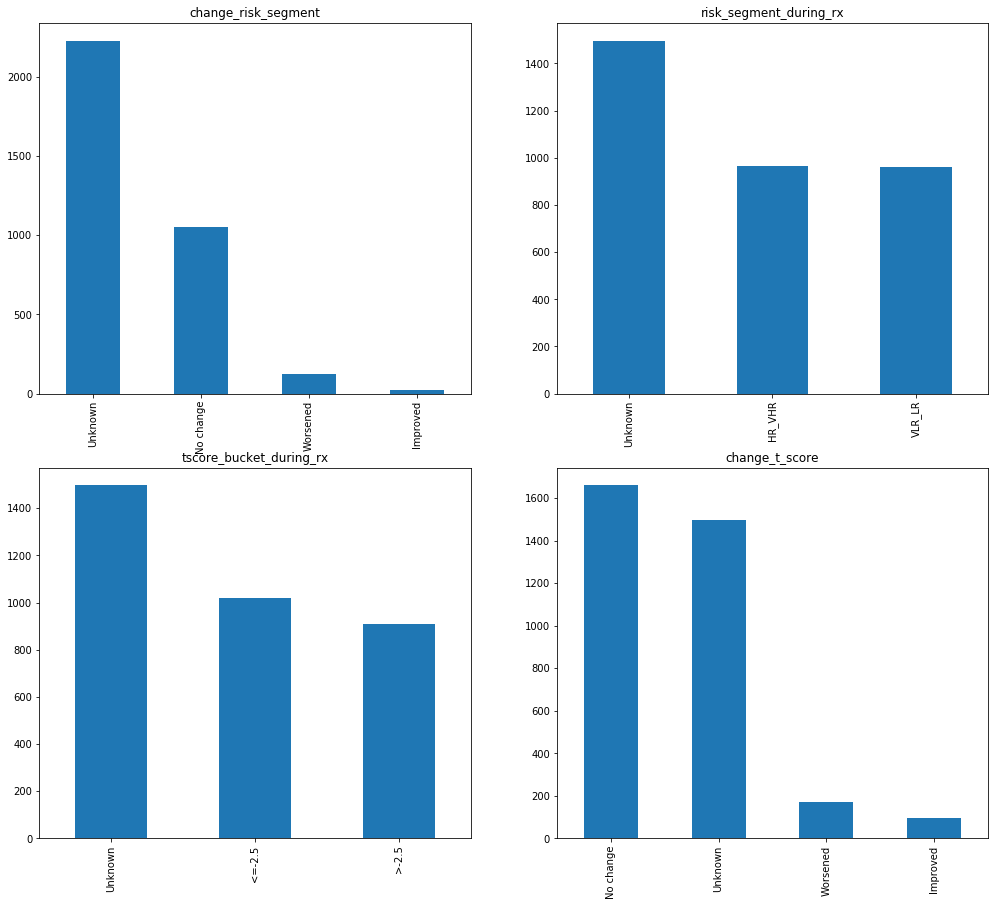

In [13]:
fig, axarr = plt.subplots(2, 2, figsize=(17, 15))
data['change_risk_segment'].value_counts().plot.bar(ax=axarr[0][0]).title.set_text('change_risk_segment')
data['risk_segment_during_rx'].value_counts().plot.bar(ax=axarr[0][1]).title.set_text('risk_segment_during_rx')
data['tscore_bucket_during_rx'].value_counts().plot.bar(ax=axarr[1][0]).title.set_text('tscore_bucket_during_rx')
data['change_t_score'].value_counts().plot.bar(ax=axarr[1][1]).title.set_text('change_t_score')

As we can see from the above graph, the majority of their values are 'Unknown'. These columns would not benefit us, so we can drop them.

In [14]:
data = data.drop(['change_risk_segment','risk_segment_during_rx','tscore_bucket_during_rx','change_t_score'],axis = 1)

### Data Encoding

The majority of the features are **categorical** in nature. So we have to encode them to numerical values.
We can start by converting the Yes and No values into 1's and 0's.

In [15]:
#List of yes and no features

binary_cols = ['persistency_flag','gender','ntm_specialist_flag','gluco_record_prior_ntm','gluco_record_during_rx','dexa_during_rx','frag_frac_during_rx','risk_segment_prior_ntm','tscore_bucket_prior_ntm','adherent_flag','idn_indicator','injectable_experience_during_rx','frag_frac_prior_ntm']

In [16]:
# Using the class instance for label encoding that was created for grouping the relevant buckets

for col in binary_cols:
    data[col] = le.fit_transform(data[col])

We can drop race and ethnicity which does add value to our model.

In [17]:
data = data.drop(['race','ethnicity'],axis =1)

In [18]:
#Encoding features with multiple categories
multiple_class = ['age_bucket','ntm_speciality','ntm_speciality_bucket','region']
for column in multiple_class:
    data[column] = data[column].astype('category')
    data[column] = le.fit_transform(data[column])

In [19]:
data.dtypes

ptid                               object
persistency_flag                    int32
gender                              int32
region                              int32
age_bucket                          int32
ntm_speciality                      int32
ntm_specialist_flag                 int32
ntm_speciality_bucket               int32
gluco_record_prior_ntm              int32
gluco_record_during_rx              int32
dexa_freq_during_rx                 int64
dexa_during_rx                      int32
frag_frac_prior_ntm                 int32
frag_frac_during_rx                 int32
risk_segment_prior_ntm              int32
tscore_bucket_prior_ntm             int32
adherent_flag                       int32
idn_indicator                       int32
injectable_experience_during_rx     int32
concomitancy_count                  int32
comorbidity_count                   int32
risk_factors_count                  int32
dtype: object

In [20]:
data.shape

(3424, 22)

## Feature Selection

- There are various feature selection methods for categorical data. I have used the **Mutual Information Classifier** method.
- Scikit provides a class known Select K best fetaures where we can use *Mutual Information Classifier* in the scoring function parameter.
- First we have to split the data into features and target after removing the patient id column.

In [21]:
# Splitting the data into fetaures and target ( persistency_flag ).
features = data.copy()
target = features[['persistency_flag']]
features = features.drop(['ptid','persistency_flag'],axis=1)

In [22]:
#Creating the class instance for Select K Best module

fs = SelectKBest(score_func=mutual_info_classif,k='all')
fs.fit(features , target.values.ravel())

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x0000016E408110D0>)

Each feature will be assigned a score based on their relevancy to the taret variable. We can pass those values into a dataframe and sort them based their scores 

In [25]:
feature_columns=features.columns
feature_list = []
for i in range(len(fs.scores_)):
    feature_list.append([feature_columns[i],fs.scores_[i]])
feature_df = pd.DataFrame(feature_list)
feature_df = feature_df.sort_values(1,ascending=False)
feature_df.columns = ['fetaure','score']
feature_df

,fetaure,score
17,concomitancy_count,0.157598
8,dexa_freq_during_rx,0.131468
9,dexa_during_rx,0.105821
18,comorbidity_count,0.068292
3,ntm_speciality,0.027249
16,injectable_experience_during_rx,0.025413
7,gluco_record_during_rx,0.023256
11,frag_frac_during_rx,0.015019
5,ntm_speciality_bucket,0.012312
12,risk_segment_prior_ntm,0.009358


We shall select the  **top 7** fetaures because they have some significance to the target column whereas the other columns have very low to zero significance.

In [26]:
selected_columns = feature_df['fetaure'][:7].tolist()
selected_columns

['concomitancy_count',
 'dexa_freq_during_rx',
 'dexa_during_rx',
 'comorbidity_count',
 'ntm_speciality',
 'injectable_experience_during_rx',
 'gluco_record_during_rx']

The above mentioned are the list of seven columns to be used for the model.

In [27]:
# Filtering the selected columns

feature_final = features[selected_columns]

## Fixing the imbalanced dataset using SMOTE

Now that we have selected the required features, we can fix the imbalanced dataset.

In [28]:
target['persistency_flag'].value_counts()

0    2135
1    1289
Name: persistency_flag, dtype: int64

There are more 0's **Non-Persistent flags** than 1's **Persistent flag**

We can oversample our dataset using SMOTE to increase the number of **Persistent Flags**

In [29]:
oversample = SMOTE()
feature_final,target = oversample.fit_resample(feature_final, target)

In [30]:
target['persistency_flag'].value_counts()

1    2135
0    2135
Name: persistency_flag, dtype: int64

Now there are equal number of 0's and 1's.

## Model selection and Training

### Splitting the data

We shall use a 70-30 split for training and testing sets respectively.

In [31]:
x_train, x_test,y_train, y_test = train_test_split(feature_final,target,train_size = 0.7, random_state = 8)

### Model selection

The following 5 models can be used to evaluate their performance on the given dataset,

1. Logistic Regression
2. K nearest Neighbors
3. SVC
4. Decision Trees
5. Random Forest

We can use the cross validation method to test the models performance and take the AUC score as the evaluation metric.

In [32]:
# A list to keep track of each model's performance

performance_list=[]

The following steps are going to be repeated for all the models,
1. Creating an instance
2. Training the model
3. Taking cross validation scores for 10 folds
4. Take the mean AUC score

### Logistic Regression

In [33]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train.values.ravel())
scores = cross_val_score(logreg,x_train,y_train.values.ravel(), scoring='roc_auc', cv=10)
performance_list.append(['Logistic Regression',np.mean(scores)])
print('Mean ROC AUC',np.mean(scores))

Mean ROC AUC 0.8536261578592683


### K Nearest Neighbours

Instead of choosing a random number for n_neighbors parameter we can use the cross validation k fold method to find the n_neighbors parameter.

In [34]:
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), cv=10, scoring='roc_auc')
    cv_scores.append([k,scores.mean()])
cv_scores

[[1, 0.7433857448719443],
 [3, 0.8191652670048599],
 [5, 0.841084261803027],
 [7, 0.84985431274423],
 [9, 0.8540210448792719],
 [11, 0.8541697159513395],
 [13, 0.8561589797384388],
 [15, 0.8597154482141148],
 [17, 0.8609599205410131],
 [19, 0.8609527071073029],
 [21, 0.8633598568344778],
 [23, 0.8627205244156997],
 [25, 0.8631788795217725],
 [27, 0.861934302285307],
 [29, 0.8616113775226848],
 [31, 0.8610751533902008],
 [33, 0.8608401830872163],
 [35, 0.8600614432713526],
 [37, 0.8602518405222414],
 [39, 0.8601212992849734],
 [41, 0.859075512365114],
 [43, 0.8594452381066786],
 [45, 0.8593861509961004],
 [47, 0.8601845360294291],
 [49, 0.8601980815763983]]

We shall choose 19 has the n_neighbors parameter since it has the best AUC score.

In [35]:
knn = KNeighborsClassifier(n_neighbors = 19)
knn.fit(x_train,y_train.values.ravel())
scores = cross_val_score(knn,x_train,y_train.values.ravel(), scoring='roc_auc', cv=10)
performance_list.append(['K Neighbours Classifiers',np.mean(scores)])
print('Mean ROC AUC',np.mean(scores))

Mean ROC AUC 0.8609527071073029


### Support Vector Classifier

In [36]:
svc = SVC()
svc.fit(x_train,y_train.values.ravel())
scores = cross_val_score(svc,x_train,y_train.values.ravel(), scoring='roc_auc', cv=10)
performance_list.append(['SVC',np.mean(scores)])
print('Mean ROC AUC',np.mean(scores))

Mean ROC AUC 0.857264733587759


### Decision Tree

In [37]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
scores = cross_val_score(dtc,x_train,y_train.values.ravel(), scoring='roc_auc', cv=10)
performance_list.append(['Decision Tree',np.mean(scores)])
print('Mean ROC AUC',np.mean(scores))

Mean ROC AUC 0.7844835504200587


### Random Forest

In [38]:
random_forest = RandomForestClassifier(n_estimators= 300)
random_forest.fit(x_train, y_train.values.ravel())
scores = cross_val_score(random_forest,x_train,y_train.values.ravel(), scoring='roc_auc', cv=10)
performance_list.append(['Random Forest',np.mean(scores)])
print('Mean ROC AUC',np.mean(scores))

Mean ROC AUC 0.8581278951737195


## Model Selection

We shall convert the performance metrics list to a dataframe and sort them based on scores.

In [39]:
performance_df = pd.DataFrame(performance_list)

In [40]:
performance_df.columns = ['model','train_roc']
performance_df.sort_values('train_roc',ascending = False)

,model,train_roc
1,K Neighbours Classifiers,0.860953
4,Random Forest,0.858128
2,SVC,0.857265
0,Logistic Regression,0.853626
3,Decision Tree,0.784484


The K neighbors model has the highest AUC score on the training set. We shall use K Nearest Neighbors to train our model.

## Hyperparameter tuning

We can use the grid search method to find the best parameters for our model.

In [41]:
# A dictionary which the respective test parameters
k_range = list(range(1, 50))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

In [42]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')
grid.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=19, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [43]:
print('Best Parameters:',grid.best_params_)
print('Best Score:',grid.best_score_)

Best Parameters: {'n_neighbors': 22, 'weights': 'uniform'}
Best Score: 0.8635847077687936


We can choose n_neighbors has 16 and uniform weights.

## Evaluating model performance

Evaluating model performance on the test set using various metrics.

In [44]:
#Training the model

knn = KNeighborsClassifier(n_neighbors = 16)
knn.fit(x_train,y_train.values.ravel())
knn_y_pred = knn.predict(x_test)

### Confusion matrix

In [45]:
conf_matrix = confusion_matrix(y_test,knn_y_pred)
print(conf_matrix)

[[533 115]
 [142 491]]


- True Positives : 535
- False Positives : 113
- False Negatives : 157
- True Negatives : 476

### F1 Score

In [46]:
f1_value = f1_score(y_test,knn_y_pred) 
print('F1 score:',f1_value)

F1 score: 0.7925746569814366


### AUC

In [47]:
knn_y_pred_proba = knn.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, knn_y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area under Curve:',roc_auc)

Area under Curve: 0.8586036998030153


### Plotting ROC curve

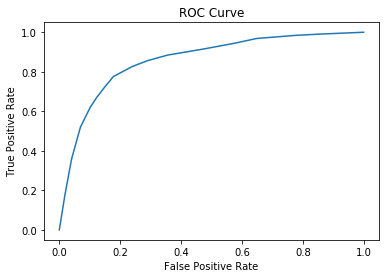

In [48]:
plt.plot(false_positive_rate, true_positive_rate)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Precision and recall values

In [49]:
class_report = classification_report(y_test,knn_y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       648
           1       0.81      0.78      0.79       633

    accuracy                           0.80      1281
   macro avg       0.80      0.80      0.80      1281
weighted avg       0.80      0.80      0.80      1281



## Conclusion:

The K Nearest Neighbors model has an AUC score of **0.86** and f1 score of **0.79** on the test set.

In [50]:
x_test.shape

(1281, 7)